In [10]:
from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import BayesianOptimization
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.Chem.Descriptors import MolWt
from sklearn.ensemble import RandomForestRegressor
import sklearn
from rdkit.Chem.rdmolops import GetFormalCharge
import torch
import deepchem as dc

import basicest as b
import chemprop_ish as c
import delfos as d
import imp

from joypy import joyplot

In [2]:
data = pd.read_csv('non_aqueous_pka_data.csv')
solute = data['Solute SMILES'].tolist()
solvent = data['Solvent SMILES'].tolist()
pka = data['pKa (avg)'].tolist()
size = len(solute)

In [3]:
#sizes
sol_set = list(set(solute))
solv_set = list(set(solvent))
print('# of unique solutes: ', len(sol_set))
print('# of unique solvents: ', len(solv_set))

# of unique solutes:  463
# of unique solvents:  8


In [8]:
#solvent sizes
print('# of solutes in each solvent:')
for solv in solv_set:
    print(solv,':',solvent.count(solv))

# of solutes in each solvent:
C(CCl)Cl : 98
O : 134
COCCOC.COCCOC : 4
CS(=O)C : 133
CC#N : 435
CN(C)C=O : 20
CCCCCCC : 4
C1CCOC1 : 65


<Figure size 432x288 with 0 Axes>

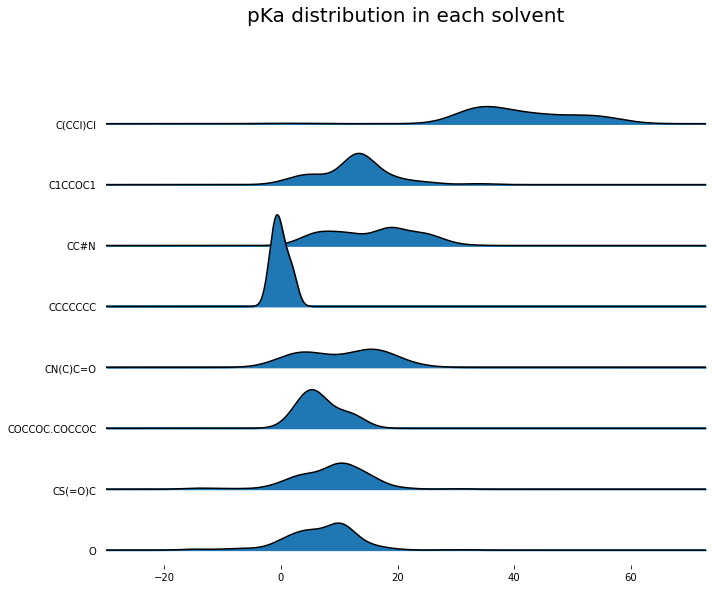

In [14]:
#pka spread in solvents
plt.figure()

joyplot(
    data=data[['pKa (avg)', 'Solvent SMILES']], 
    by='Solvent SMILES',
    figsize = (10,8)
)
plt.title('pKa distribution in each solvent', fontsize=20)
plt.show()